# Retrieving, Processing, and Visualizing Deterministic Precipitation Forecasts from ICON

This notebook demonstrates the full workflow for accessing, processing, and visualizing determinstic precipitation forecast data from the ICON numerical weather model. The data is provided by MeteoSwiss as part of Switzerland’s Open Government Data (OGD) initiative.

The core functionality is powered by the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — developed in-house to simplify working with numerical weather model data. It includes the `ogd_api` module for data access, along with utilities for applying temporal and spatial operators to model output, such as deaccumulation and regridding.

For visualization, this notebook uses the [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html) library developed by ECMWF, which offers intuitive plotting tools for meteorological data.

---

## 🔍 **What You’ll Do in This Notebook**

1. 🛰️  **Retrieve**  
    Fetch deterministic forecast data (e.g., total precipitation from ICON) via the `ogd_api` module.

2. 🧪  **Deaggregate**  
    Convert precipitation accumulated over the total forecast duration into hourly values.

3. 🧭  **Regrid**  
    Interpolate ICON data from its native, icosahedral grid to a regular latitude/longitude grid.

4. 🌍  **Visualize**  
    Plot the processed data on a map with meteorological styling using [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html).

---

## Retrieving Precipitation Forecast
In this first part, we retrieve precipitation forecast data from the ICON numerical weather model. To access this data, we use the `ogd_api` module from the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — a convenient interface for accessing numerical weather forecasts via the [STAC (SpatioTemporal Asset Catalog) API](https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAsset), which provides structured access to Switzerland’s open geospatial data.

#### 📁  Browsing the STAC Catalog (Optional)

If you'd like to explore the ICON forecast datasets interactively before writing code, you can browse them directly in the STAC catalog:

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH1-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch1?.language=en)

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH2-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch2?.language=en)


Below is a screenshot of the ICON-CH2-EPS collection as seen in the STAC browser interface.


![browser-ch2-resized.PNG](./images/browser-ch2-resized.PNG)

⚠️ **Temporary Setup Notice**

We currently use **ecCodes 2.36.0**, which requires manually setting the `ECCODES_DIR` environment variable to locate the binary library.
The [install_eccodes.sh](./install_eccodes.sh) script prints the full path to the installed environment — use that path here.

From **ecCodes 2.37.0** onwards, this step won't be needed as the Python wheel will include the binary automatically.

In [1]:
from pathlib import Path
import os

# Replace this with the actual environment path if different
os.environ["ECCODES_DIR"] = str(Path.home()) + "/miniconda3/envs/eccodes_env"

### Creating Requests
To retrieve the forecast data, we first define a set of API requests using the `ogd_api.Request` class.
Each request targets a different lead time, which is the elapsed time since the forecast's start time (reference or initialization datetime).
In this example, we retrieve hourly precipitation accumulations (`TOT_PREC`) for three consecutive lead times: +0h, +1h and +2h. Each hourly forecast value includes all precipitation from the reference time up to the corresponding lead time.

>⏰ **Forecast Availability**: Forecast data will typically be available a couple of hours after the reference time — due to the model runtime and subsequent upload time. The data remains accessible for 24 hours after upload.

In [2]:
from meteodatalab import ogd_api

amount_of_lead_times = 3
reqlist = []

for i in range(amount_of_lead_times):
    req = ogd_api.Request(
        collection="ogd-forecasting-icon-ch2",
        variable="TOT_PREC",
        reference_datetime="2025-04-09T12:00:00Z", # make sure to change the date
        perturbed=False,
        horizon=f"P0DT{i}H",
    )
    reqlist.append(req)

Each argument in the request serves the following purpose:

| Argument             | Description |
|----------------------|-------------|
| `collection`         | Forecast collection to use (e.g., `ogd-forecasting-icon-ch2`). |
| `variable`           | Meteorological variable of interest (`TOT_PREC` = total precipitation). |
| `reference_datetime` | Initialization time of the forecast in **UTC** (e.g., `2025-04-09T12:00:00Z`). |
| `perturbed`          | If `True`, retrieves ensemble forecast members; if `False`, returns the deterministic forecast. |
| `horizon`            | Forecast lead time, provided as either:<br>– `ISO 8601` duration string (e.g., `P0DT2H`)<br>– `datetime.timedelta` object (e.g., `datetime.timedelta(hours=2)`) |

### Retrieving Data
We now send our list of requests to the API and retrieve the resulting datasets using the `get_from_ogd()` function.
Each response is returned as an **[xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html)**, which is efficient for handling multi-dimensional data.

> 💡 **Tip**: Use temporary caching with earthkit-data to skip repeated downloads — it's auto-cleaned after the session.
> *For more details, see the [earthkit-data caching docs](https://earthkit-data.readthedocs.io/en/latest/examples/cache.html)*.

> 💡 **Hint**: If you get an error message containing "HTTPError: 403 Client Error: Forbidden for url", you may be trying to retrieve data older than 24h hours! Please adjust your requests.

In [3]:
from earthkit.data import config
config.set("cache-policy", "temporary")

da_list = []
for req in reqlist:
    da = ogd_api.get_from_ogd(req)
    da_list.append(da)

## Data Preprocessing

Once the data has been loaded, continue with the preprocessing of the data if needed. The following preprocessing steps
are described here:
- Merging the data array containing the different lead times into one array
- Disaggregating the accumulated precipitation data
- Regridding the data to a regular latitude/longitude grid

### Merging Lead Times
To work with a continuous time series, we concatenate forecast data for different lead times into a single `xarray.DataArray`.

In [4]:
import xarray as xr
tot_prec = xr.concat(da_list, dim="lead_time")
tot_prec

<xarray.DataArray (eps: 1, ref_time: 1, lead_time: 3, cell: 283876)> Size: 3MB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 8B 0
  * ref_time    (ref_time) datetime64[ns] 8B 2025-04-09T12:00:00
  * lead_time   (lead_time) timedelta64[ns] 24B 00:00:00 01:00:00 02:00:00
    lon         (cell) float32 1MB -0.1544 -0.1637 -0.1915 ... 12.82 12.83 12.81
    lat         (cell) float32 1MB 46.97 46.98 46.98 47.13 ... 50.08 50.06 50.05
    valid_time  (ref_time, lead_time) datetime64[ns] 24B 2025-04-09T12:00:00 ...
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.readers.grib.metadata.StandAloneGribMetadata...
    parameter:    {'centre': 'lssw', 'paramId': 500041, 'shortName': 'TOT_PRE...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  surface
    origin_z:     0.0

The resulting `xarray.DataArray` has the following dimensions:

- `eps` (ensemble members): 1 member (for deterministic data)
- `ref_time`: Single reference time (e.g. 2025-04-09 12:00:00 UTC)
- `lead_time`: 3 hourly intervals
- `cell`: 283,876 spatial grid points

It includes attributes specifying some meta data such as:

- `parameter`: information on the meteorogical parameter, here total precipitation
- `vcoord_type`: information of the vertical coordinate type, here surface field

> &#x1F525; **Expert users:** If you are interested in detailed meta data information, i.e. the GRIB encodings, you can retrieve it from the `metadata` attribute.
Please refer to the [earthkit-data metadata documentation](https://earthkit-data.readthedocs.io/en/latest/examples/metadata.html).

### Disaggregating Precipitation
Convert precipitation accumulated over the whole forecast time into one-hour precipitation by differencing consecutive lead times. This is done using the `delta()` function from [meteodatalab](https://meteoswiss.github.io/meteodata-lab/), which simplifies the operation.

In [5]:
from meteodatalab.operators import time_operators as time_ops
import numpy as np

prec_1h = time_ops.delta(tot_prec, np.timedelta64(1,"h"))

For the next steps, we'll work with a **single lead time** from the forecast.
Xarray's `.isel()` method lets us easily select along a specific dimension — here, we use it to pick one lead time.


In [6]:
prec = prec_1h.isel(lead_time=2)

### Regridding to a Regular Grid
To enable visualization or comparison with other geospatial datasets, you may want to regrid the ICON data from its native, unstructured grid onto a regular latitude/longitude grid. This can be done using the `regrid` utilities provided by [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/).

Below, we define the target grid using a bounding box over the area of interest, specify the output resolution, and apply the remapping.


In [7]:
from rasterio.crs import CRS
from meteodatalab.operators import regrid

# Define the target grid extent and resolution
xmin, xmax = -0.817, 18.183   # Longitude bounds
ymin, ymax = 41.183, 51.183   # Latitude bounds
nx, ny = 950, 500             # Number of grid points in x and y

# Create a regular lat/lon grid using EPSG:4326
destination = regrid.RegularGrid(
    CRS.from_string("epsg:4326"), nx, ny, xmin, xmax, ymin, ymax
)

# Remap ICON native grid data to the regular grid
prec_geo = regrid.iconremap(prec, destination)

## Visualizing Precipitation on a Map
We now visualize the 1-hour precipitation on a map. This uses [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html), the visualization component of [Earthkit](https://earthkit.readthedocs.io/en/latest/) — a suite of tools designed to simplify access, processing, and visualization of weather and climate data in Python.

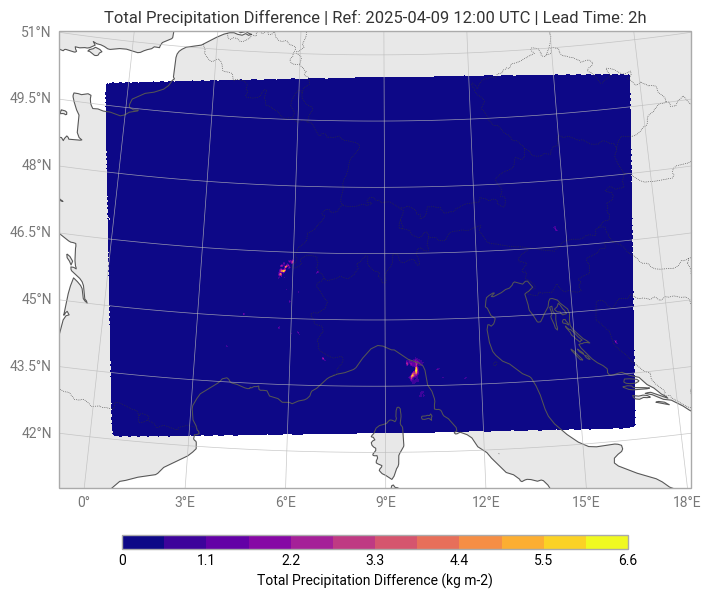

In [8]:
from earthkit.plots.geo import domains
import earthkit
import numpy as np
import pandas as pd

# Define the map domain using the regridded data's bounding box
domain = domains.Domain.from_bbox(
    bbox=[xmin, xmax, ymin, ymax],
    name="CH2"
)

# Create the map instance
chart = earthkit.plots.Map(domain=domain)

# Plot the regridded precipitation field
chart.block(prec_geo, x="lon", y="lat")

# Add standard map features
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()

# Extract forecast metadata
ref_time = pd.to_datetime(prec_geo.coords["ref_time"].values[0]).strftime("%Y-%m-%d %H:%M UTC")
lead_ns = prec_geo.coords["lead_time"].values
lead_hours = pd.to_timedelta(lead_ns).total_seconds() / 3600
lead_time = f"{lead_hours:.0f}h"

# Prepare title and legend labels
parameter = prec_geo.attrs["parameter"]
title = f"{parameter['name']} | Ref: {ref_time} | Lead Time: {lead_time}"
legend_label = f"{parameter['name']} ({parameter['units']})"

# Add title and legend to the map
chart.title(title)
chart.legend(label=legend_label)

# Display the map
chart.show()